# Creating dataframe for storing SATAY information for each genomic region
This notebook is based on the following codes

- genomicfeatures_dataframe_with_normalization.py
- normalize_reads.py (which is used as a function in the first script)

## Introduction

The number of reads indicates how well a cell can grow when it has a transposon inserted in a specific genomic region.
This can be converted to a fitness level, similarly as was done in [Costanzo et.al. 2013](https://experts.umn.edu/en/publications/genetic-networks).
Potentially this can be used to determine interactions (and whether they are positive or negative) between genes.
This can be done by using two datasets resulting from SATAY experiments, one wild type and one deletion strain.
From the wild type, the fitness can be determined for two genes, called A and B, that both have a transposon insertion (which is equivalent to two single deletions, $\Delta$A and $\Delta$B).
Next, the actual deletion strain from $\Delta$B is measured as well using SATAY.
From this deletion strain, the fitness can be determined for a transposon insertion in gene A (which is equivalent to a double deletion $\Delta$A$\Delta$B).
The expected fitness based on the fitness A and B from the wild type SATAY experiments (where fitness is defined as *a* and *b* respectively) is assumed to be equal to the multiplication of the indivual fitnesses (*a* $\cdot$ *b*) and the actual fitness can be determined based on the SATAY experiments from the $\Delta$B strain (defined as *ab*).
Any difference between the expected fitness and the actual fitness indicates possible interactions between the genes A and B (thus the interaction score = *ab* - *a* times *b*).
If the difference is positive (meaning that the actual fitness is higher than the expected fitness, *ab* $>$ *a* $\cdot$ *b*), there is positive interaction and when the difference is negative (actual fitness is lower than the expected fitness, *ab* $<$ *a* $\cdot$ *b*) there is negative interaction.

To estimate the fitness of the cells, the reads need to be normalized.
This has to be done with a certain caution, since the likelyhood of a transposon insertion is not constant throughout the genome or within a chromosome and also not between experiments.
Basically, there are three things to normalize for.

1. Differences in gene length
2. Interchromosomal differences, e.g. due to the higher likelihood of transposon insertion near the centromeres
3. Between experimental differences, since different experiments typically have different amount of reseeded cells, transposon insertions and reads.

The current method is to define the several windows (e.g. each of 20000bp in length).
Each of these windows are normalized individually and independent of the other windows.
The normalization is done based on the neutral genomic regions, which are regions that do not code for genes or other features that might influence the fitness of the cells when they are inhibited by a transposon insertion.
This should create a relative flat distribution where locations with few reads correspond to important (or potentially essential) genomic regions and, similarly, locations with many reads correspond to regions that are not important for proliferation or might even be beneficial when inhibited.

Based on the points noted above, the following equation is used for normalizing the reads within a genomic region (see also [Gallagher et.al. 2011](https://mbio.asm.org/content/mbio/2/1/e00315-10.full.pdf))

$N_{NormalizedReads} = \sum \limits_{\forall insertions} N_{RawReads} \cdot \frac{1}{l_{region}} \cdot \frac{10^6}{N_{TotalReadsGenome}} \cdot \frac{\overline{ReadDensityChromosome}}{\overline{ReadDensityWindow}}$.

For genes, the sum is over all insertions in the central part of the gene.
The insertions in the first and last part (e.g. first and last 10% or first and last 100bp) are ignored as a tranposon insertion in those regions can still yield a function, though truncated, protein.
For the other genomic regions, insertions in the entire length are considered.
For the average read density in the chromosome ($\overline{ReadDensityChromosome}$) only the noncoding regions are considered, since those regions are considered to be neutral and a transposon insertions is expected not to have a major influence on the cell fitness.
This script determines the normalized reads per genomic region according to the described method and stores the normalized reads per genomic region in a dataframe together with some other information about the regions.



## The code explained

The main output of the code is a dataframe that, for each chromosome, stores information per genomic region.
Genomic regions are defined as

- Open Reading Frame (ORF)
- Autonomously Replication Sequence (ARS)
- Telomere
- Long terminal repeat
- Centromere
- X element
- Intron
- ncRNA gene
- tRNA gene
- snoRNA gene
- snRNA gene
- rRNA gene
- Transposable element gene
- 5' UTR intron
- Matrix attachment site
- External transcribed spacer region
- Internal transcribed spacer region
- origin of replication
- Telomere RNA gene

A chromosome is defined in the above regions and all other regions are defined as being noncoding DNA.
For each of the above windows, the normalization is applied according to the above equation using the custom function `reads_normalization` in [normalize_reads.py](https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis/blob/dev_Gregory/Python_scripts/python_modules/normalize_reads.py).

To store all information regarding the different regions and the number of insertions and reads and their normalization, a dataframe is created.
This dataframe is also the main output of the function described here.
In the dataframe the different genomic regions are defined as features in a specified chromosome and the following information is stored for each feature:

1. Feature name; oln naming convention, e.g. 'YLR229C'
2. Standard name; e.g 'CDC42'
3. Feature alias; any aliases for a gene
4. Feature type
5. Essentiality; only defined for genes (either True of False), for all other regions this is set to None
6. Position; list with the start and end position of the feature in the chromosome
7. Number of basepairs
8. Number of insertions
9. Number of insertions in the central part of the gene; this is only done for the genes, for the other features this column is the same as the previous column
10. Number of reads
11. Number of reads in the central part of the gene; this is only done for the genes, for the other features this column is the same as the previous column
12. Number of insertions per basepair; insertions normalized for the different lengths of the features.
13. Number of insertions per basepair in the central part of the gene; this is only done for the genes, for the other features this column is the same as the previous column
14. Number of reads per basepair; reads normalized for the different lengths of the features.
15. Number of reads per basepair in the central part of the gene; this is only done for the genes, for the other features this column is the same as the previous column
16. Number of reads per basepair normalized; normalization according to the previously described method
17. Number of reads per basepair in the central part of the gene normalized; this is only done for the genes, for the other features this column is the same as the previous column
18. Number of reads per basepair in the central part of the gene normalized with an extra normalization step where in each window all feaures are divided by the average number of reads after normalization in the noncoding regions; this should set the normalized reads in the noncoding regions to about 1 and all features that have normalized reads above 1 are more fit than normal and below 1 are less fit than normal.


### packages
The code relies on the packages loaded in the first cell of this notebook.
The user settings are in the second cell (for a brief explanation, see below).
There are some additional files that are loaded (see cell 3), for which the location is defined using the relative path of this script.
For first time use, check if the relative path to the files is correct.

### Input
- Region: e.g. chromosome number (either a normal number between 1 and 16 or in roman numerals between I and XVI), a list like ['V', 0, 14790] which creates a barplot between basepair 0 and 14790) or a genename.
- wig_file: wiggle file from the output of transposonmapping.py that is used in the processing workflow.
- pergene_insertions_file: text file from the output of transposonsmapping.py
- variable: either 'insertions' or 'reads', which determines what is being plotted.
- normalize: either True or False. Normalization only works for when variable is 'reads'. The normalized reads are plotted and adds a column to the dataframe.
- normalization_window_size: Integer. Normalization relies on windows that corrects for inter chromosomal differences. This determine the size of those windows in terms of basepairs (default=10000)
- plotting: Either True or False. Determines whether the barplot has to be created.
- savefigure: Whether to save the figure at the same location of this script.
- Verbose: Either True of False. Determines how much textual feedback is given. When set to False, only warnings will be shown.

###  Output:
- dna_df2: Dataframe containing information about the selected chromosome.

### Required files:
- [essentials_file](https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis/blob/master/Data_Files/Cerevisiae_AllEssentialGenes_List.txt)
- [gene_information_file](https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis/blob/master/Data_Files/Yeast_Protein_Names.txt)
- [gff-file](https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis/blob/master/Data_Files/Saccharomyces_cerevisiae.R64-1-1.99.gff3)
- [sgd_features_file](https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis/blob/master/Data_Files/SGD_features.tab)


## The code

In [31]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


file_dirname = os.path.dirname(os.path.abspath('__file__'))
from chromosome_and_gene_positions import chromosome_position, chromosomename_roman_to_arabic, gene_position
from chromosome_names_in_files import chromosome_name_wigfile
from gene_names import list_gene_names, gene_aliases
from read_sgdfeatures import sgd_features
from normalize_reads import reads_normalization
sys.path.insert(1,os.path.join(file_dirname,'..','fitness_from SATAY_codes'))
from genomicfeatures_dataframe_with_normalization_genomeplot import genome_normalization_plot

### User settings
(See input section in the above text)

In [32]:
region = 1
wig_file = r"C:\Users\gregoryvanbeek\Documents\testing_site\wt1_testfolder_S288C\align_out\ERR1533147_trimmed.sorted.bam.wig"
pergene_insertions_file = r"C:\Users\gregoryvanbeek\Documents\testing_site\wt1_testfolder_S288C\align_out\ERR1533147_trimmed.sorted.bam_pergene_insertions.txt"
variable="reads"
normalize=True
normalization_window_size = 20000
plotting=True
savefigure=False
verbose=True

### Loading data files

In [33]:
essentials_file = r"C:\Users\gregoryvanbeek\Documents\GitHub\LaanLab-SATAY-DataAnalysis\Python_scripts\Data_Files\Cerevisiae_AllEssentialGenes_List.txt"

gene_information_file = os.path.join(file_dirname,'..','Data_Files','Yeast_Protein_Names.txt')

gff_file = os.path.join(file_dirname,'..','Data_Files','Saccharomyces_cerevisiae.R64-1-1.99.gff3')

sgd_features_file = os.path.join(file_dirname,'..','Data_Files','SGD_features.tab')

variable = variable.lower()
if plotting == True:
    create_plottitle = ''

### Determine the specified region
The region can be specified as follows (in the user settings section):

- chromosome (i.e. as a roman or arabic numeral)
- list in the form `['I', 100, 1000]` which would create a dataframe for chromosome I, but plot only the region between basepair 100 and 1000 of chromosome I.
- gene name, e.g. `cdc42`

In [34]:
warningmessage = "WARNING: Specified chromosome or gene name not found. Enter chromosome as a number (or roman numeral) between 1 and 16 (I and XVI), a list in the form ['chromosome number, start_position, end_position'] or a valid gene name."

if type(region) == str:
    if region.upper() in chromosomename_roman_to_arabic()[1]:
        chrom = region.upper()
        roi_start = None
        roi_end = None

    elif region.upper() in list_gene_names(gene_information_file):
        gene_pos_dict = gene_position(gff_file)
        region = region.upper()
        if region in gene_pos_dict:
            region_pos = gene_pos_dict.get(region)
            chrom = region_pos[0]
            roi_start = int(region_pos[1])
            roi_end = int(region_pos[2])
        else:
            gene_alias_dict = gene_aliases(gene_information_file)[0]
            region_alias = [key for key, val in gene_alias_dict.items() if region in val]
            if not region_alias == [] and region_alias[0] in gene_pos_dict:
                region_pos = gene_pos_dict.get(region_alias[0])
                chrom = region_pos[0]
                roi_start = int(region_pos[1])-100
                roi_end = int(region_pos[2])+100
                del (region_alias, gene_alias_dict)
            else:
                print(warningmessage)
#                    return()
        if plotting == True:
            create_plottitle = region
        del (region_pos, gene_pos_dict)

    else:
        print(warningmessage)
#            return()


elif type(region) == list:
    if type(region[0]) == str:
        chrom = region[0].upper()
    elif type(region[0]) == int:
        if region[0] in chromosomename_roman_to_arabic()[0]:
            chrom = chromosomename_roman_to_arabic()[0].get(region[0])
    else:
        print(warningmessage)
#            return()
    roi_start = region[1]
    roi_end = region[2]


elif type(region) == int:
    if region in chromosomename_roman_to_arabic()[0]:
        chrom = chromosomename_roman_to_arabic()[0].get(region)
        roi_start = None
        roi_end = None
    else:
        print(warningmessage)
#            return()


else:
    print(warningmessage)
#        return()


del (region, warningmessage)

### Read wig file
Get all transposon insertion locations.

In [35]:
with open(wig_file, 'r') as f:
    lines = f.readlines()

chrom_start_line_dict, chrom_end_line_dict = chromosome_name_wigfile(lines)[1:]

insrt_in_chrom_list = []
reads_in_chrom_list = []
for l in lines[chrom_start_line_dict.get(chrom):chrom_end_line_dict.get(chrom)]:
    insrt_in_chrom_list.append(int(l.strip('\n').split(' ')[0]))
    reads_in_chrom_list.append(int(l.strip('\n').split(' ')[1]))

del (lines, l, f, chrom_start_line_dict, chrom_end_line_dict)

### Read pergene_insertions file
Get the location of transposon insertion in each gene.

In [36]:
with open(pergene_insertions_file) as f:
    lines = f.readlines()


gene_position_dict = {}
for line in lines[1:]:
    line_split = line.strip('\n').split('\t')


    if line_split[1] == chrom:
        genename = line_split[0]
        gene_chrom = line_split[1]
        gene_start = int(line_split[2])
        gene_end = int(line_split[3])

        gene_position_dict[genename] = [gene_chrom, gene_start, gene_end] #DICT CONTAINING ALL GENES WITHIN THE DEFINED CHROMOSOME INCLUDING ITS START AND END POSITION


        geneinserts_str = line_split[4].strip('[]')
        if not geneinserts_str == '':
            geneinserts_list = [int(ins) for ins in geneinserts_str.split(',')]
        else:
            geneinserts_list = []


        genereads_str = line_split[5].strip('[]')
        if not genereads_str == '':
            genereads_list = [int(read) for read in genereads_str.split(',')]
        else:
            genereads_list = []


        if len(geneinserts_list) != len(genereads_list):
            print('WARNING: %s has different number of reads compared with the number of inserts' % genename )


del (f, lines, line, line_split, genename, gene_chrom, gene_start, gene_end, geneinserts_list, geneinserts_str, genereads_str, genereads_list)


### Initialize the variable for storing all genomic features
The main variable in the next section is dna_dict which includes all basepairs in the chromosome as keys and the values are the feature type.
Initialization is done by setting all basepairs as belonging to a noncoding region. The next section overwrites the basepairs that actually belong to another region.

In [37]:
len_chr = chromosome_position(gff_file)[0].get(chrom)
start_chr = chromosome_position(gff_file)[1].get(chrom)
end_chr = chromosome_position(gff_file)[2].get(chrom)

dna_dict = {} #for each bp in chromosome, determine whether it belongs to a noncoding or coding region
for bp in range(start_chr, end_chr + 1): #initialize dna_dict with all basepair positions as ['noncoding', None]
    dna_dict[bp] = ['noncoding', None] #form is: ['element_name', 'type']


feature_orf_dict = sgd_features(sgd_features_file)[1]
gene_alias_dict = gene_aliases(gene_information_file)[0]


for gene in gene_position_dict:
    if gene in feature_orf_dict:
        if (not gene.endswith("-A") and not feature_orf_dict.get(gene)[1] == 'Verified') and (not gene.endswith("-B") and not feature_orf_dict.get(gene)[1] == 'Verified'):
            for bp in range(gene_position_dict.get(gene)[1]+start_chr, gene_position_dict.get(gene)[2]+start_chr+1):
                dna_dict[bp] = [gene, "Gene; "+feature_orf_dict.get(gene)[1]]
    else:
        gene_alias = [key for key, val in gene_alias_dict.items() if gene in val][0]
        for bp in range(gene_position_dict.get(gene)[1]+start_chr, gene_position_dict.get(gene)[2]+start_chr+1):
            dna_dict[bp] = [gene_alias, "Gene; "+feature_orf_dict.get(gene_alias)[1]]


del (gff_file, gene, bp, gene_alias)

### Determine the location of all genomic features
In dna_dict overwrite all basepairs values that belong to a feature.
For this a function is used called feature_position which is directly included in this code.

In [38]:
def feature_position(feature_dict, chrom, start_chr, dna_dict, feature_type=None):
    
    position_dict = {}
    for feat in feature_dict:
        if feature_dict.get(feat)[5] == chrom:
#            if feat.startswith("TEL") and feat.endswith('L'): #correct for the fact that telomeres at the end of a chromosome are stored in the reverse order.
            if int(feature_dict.get(feat)[6]) > int(feature_dict.get(feat)[7]):
                position_dict[feat] = [feature_dict.get(feat)[5], feature_dict.get(feat)[7], feature_dict.get(feat)[6]]
            else:
                position_dict[feat] = [feature_dict.get(feat)[5], feature_dict.get(feat)[6], feature_dict.get(feat)[7]]


    for feat in position_dict:
        for bp in range(int(position_dict.get(feat)[1])+start_chr, int(position_dict.get(feat)[2])+start_chr):
            if dna_dict[bp] == ['noncoding', None]:
                dna_dict[bp] = [feat, feature_type]
            else:
#                print('Bp %i is already occupied by %s' % (bp, str(dna_dict.get(bp))))
                pass


    return(dna_dict)

genomicregions_list = sgd_features(sgd_features_file)[0]

i = 2
for genomicregion in genomicregions_list[1:]:
    dna_dict = feature_position(sgd_features(sgd_features_file)[i], chrom, start_chr, dna_dict, genomicregion)
    i += 1


### TEST IF ELEMENTS IN FEATURE_ORF_DICT FOR SELECTED CHROMOSOME ARE THE SAME AS THE GENES IN GENE_POSITION_DICT BY CREATING THE DICTIONARY FEATURE_POSITION_DICT CONTAINING ALL THE GENES IN FEATURE_ORF_DICT WITH THEIR CORRESPONDING POSITION IN THE CHROMOSOME
gene_alias_dict = gene_aliases(gene_information_file)[0]
orf_position_dict = {}
for feature in feature_orf_dict:
    if feature_orf_dict.get(feature)[5] == chrom:
        if feature in gene_position_dict:
            orf_position_dict[feature] = [feature_orf_dict.get(feature)[6], feature_orf_dict.get(feature)[7]]
        else:
            for feature_alias in gene_alias_dict.get(feature):
                if feature_alias in gene_position_dict:
                    orf_position_dict[feature_alias] = [feature_orf_dict.get(feature)[6], feature_orf_dict.get(feature)[7]]



if sorted(orf_position_dict) == sorted(gene_position_dict):
    if verbose == True:
        print('Everything alright, just ignore me!')
    else:
        pass
else:
    print('WARNING: Genes in feature_list are not the same as the genes in the gene_position_dict. Please check!')


del (sgd_features_file, feature_orf_dict, orf_position_dict, feature, feature_alias, gene_position_dict)


Everything alright, just ignore me!


### Determine the number of reads for each insertion within a region.

In [39]:
reads_loc_list = [0] * len(dna_dict) # CONTAINS ALL READS JUST LIKE READS_IN_CHROM_LIST, BUT THIS LIST HAS THE SAME LENGTH AS THE NUMBER OF BP IN THE CHROMOSOME WHERE THE LOCATIONS WITH NO READS ARE FILLED WITH ZEROS
i = 0
for ins in insrt_in_chrom_list:
    reads_loc_list[ins] = reads_in_chrom_list[i]
    i += 1


del (i, ins, insrt_in_chrom_list, reads_in_chrom_list)#, dna_df)

### Create dataframe
Create dataframe dna_df2, which includes all information gathered from the data.

In [40]:
feature_NameAndType_list = []
f_previous = dna_dict.get(start_chr)[0]
f_type = dna_dict.get(start_chr)[1]
N_reads = []
N_reads_list = []
N_reads_central80_list = []
N_insrt_central80_list = []
N_insrt_list = []
N_bp = 1
N_bp_list = []
f_start = 0
f_end = 0
f_pos_list = []
i = 0
for bp in dna_dict:
    f_current = dna_dict.get(bp)[0]
    if f_current == f_previous:
        f_type = dna_dict.get(bp)[1]
        f_end += 1
        N_bp += 1
        N_reads.append(reads_loc_list[i])
    elif (f_current != f_previous or (i+start_chr) == end_chr):# and not f_current.endswith('-A'):
        feature_NameAndType_list.append([f_previous, f_type])
        N_reads_list.append(sum(N_reads))
        N_insrt_list.append(len([ins for ins in N_reads if not ins == 0]))
        if not f_type == None and f_type.startswith('Gene'):
            N10percent = 100#int(len(N_reads) * 0.1)
            N_reads_central80_list.append(sum(N_reads[N10percent:-N10percent]))
            N_insrt_central80_list.append(len([ins for ins in N_reads[N10percent:-N10percent] if not ins == 0]))
        else:
            N_reads_central80_list.append(sum(N_reads))
            N_insrt_central80_list.append(len([ins for ins in N_reads if not ins == 0]))

        N_bp_list.append(N_bp)
        N_reads = []
        N_bp = 1
        f_pos_list.append([f_start, f_end+f_start])
        f_start = f_start + f_end + 1
        f_end = 0
        f_previous = f_current
    i += 1

N_reads_per_bp_list = []
N_reads_per_bp_central80p_list = []
N_insrt_per_bp_list = []
N_insrt_per_bp_central80p_list = []
for i in range(len(N_reads_list)):
    N_reads_per_bp_list.append(N_reads_list[i]/N_bp_list[i])
    N_insrt_per_bp_list.append(N_insrt_list[i]/N_bp_list[i])
    if not feature_NameAndType_list[i][1] == None and feature_NameAndType_list[i][1].startswith('Gene'):
        N_reads_per_bp_central80p_list.append(N_reads_central80_list[i]/(N_bp_list[i]*0.8))
        N_insrt_per_bp_central80p_list.append(N_insrt_central80_list[i]/(N_bp_list[i]*0.8))
    else:
        N_reads_per_bp_central80p_list.append(N_reads_list[i]/N_bp_list[i])
        N_insrt_per_bp_central80p_list.append(N_insrt_list[i]/N_bp_list[i])


#############get all essential genes together with their aliases##############
with open(essentials_file, 'r') as f:
    essentials_temp_list = f.readlines()[1:]
essentials_list = [essential.strip('\n') for essential in essentials_temp_list]
del essentials_temp_list

gene_alias_dict = gene_aliases(gene_information_file)[0]
for key, val in gene_alias_dict.items():
    if key in essentials_list:
        for alias in val:
            essentials_list.append(alias)

#ADD
essentiality_list = []
for feature in feature_NameAndType_list:
    if not feature[0] == "noncoding":
        if feature[1] in genomicregions_list:
            essentiality_list.append(None)
        elif feature[0] in essentials_list:
            essentiality_list.append(True)
        else:
            essentiality_list.append(False)
    else:
        essentiality_list.append(None)

del (key, val, alias, essentials_list, feature, gene_information_file)#, gene_alias_dict)#, reads_loc_list)
##############################################################################

feature_name_list = []
feature_type_list = []
feature_alias_list = []
feature_standardname_list = []
for feature_name in feature_NameAndType_list:
    feature_name_list.append(feature_name[0])
    feature_type_list.append(feature_name[1])
    if feature_name[1] != None and feature_name[1].startswith('Gene') and feature_name[0] in gene_alias_dict:
        if gene_alias_dict.get(feature_name[0])[0] == feature_name[0]:
            feature_standardname_list.append(feature_name[0])
            feature_alias_list.append('')
        else:
            if len(gene_alias_dict.get(feature_name[0])) > 1:
                feature_standardname_list.append(gene_alias_dict.get(feature_name[0])[0])
                feature_alias_list.append(gene_alias_dict.get(feature_name[0])[1:])
            else:
                feature_standardname_list.append(gene_alias_dict.get(feature_name[0])[0])
                feature_alias_list.append('')
    else:
        feature_standardname_list.append(feature_name[0])
        feature_alias_list.append('')


all_features = {'Feature_name': feature_name_list,
                'Standard_name': feature_standardname_list,
                'Feature_alias':feature_alias_list,
                'Feature_type': feature_type_list,
                'Essentiality': essentiality_list,
                'position': f_pos_list,
                'Nbasepairs':N_bp_list,
                'Ninsertions':N_insrt_list,
                'Ninsertions_gene_central80p':N_insrt_central80_list,
                'Nreads':N_reads_list,
                'Nreads_gene_central80p':N_reads_central80_list,
                'Ninsertionsperbp':N_insrt_per_bp_list,
                'Ninsertionsperbp_gene_central80p':N_insrt_per_bp_central80p_list,
                'Nreadsperbp':N_reads_per_bp_list,
                'Nreadsperbp_gene_central80p':N_reads_per_bp_central80p_list}

dna_df2 = pd.DataFrame(all_features, columns = [column_name for column_name in all_features]) #search for feature using: dna_df2.loc[dna_df2['Feature'] == 'CDC42']
#CREATE NEW COLUMN WITH ALL DOMAINS OF THE GENE (IF PRESENT) AND ANOTHER COLUMN THAT INCLUDES LISTS OF THE BP POSITIONS OF THESE DOMAINS

del (dna_dict, feature_NameAndType_list, feature_name_list, feature_type_list, feature_name, f_type, f_previous, f_start, f_end, f_pos_list, f_current, N_reads, N_reads_list, N_insrt_list, N_reads_central80_list, N_insrt_central80_list, N_insrt_per_bp_central80p_list, N_reads_per_bp_central80p_list, N10percent, N_bp, N_bp_list, bp, i, N_reads_per_bp_list, N_insrt_per_bp_list, start_chr, end_chr, all_features, essentiality_list, essentials_file, genomicregions_list)


### Normalize
The next section normalizes the data.
This is done in a function stored in the script normalize_reads.py.

In [41]:
dna_df2, window_edge_list = reads_normalization(dna_df2, len_chr, normalization_window_size, wig_file)


### Plotting
The output barplot discriminates the featurse using different colors and the width of the bars corresponds to the length of the features.
The grey and white background bars indicate the different windows used for normalization.

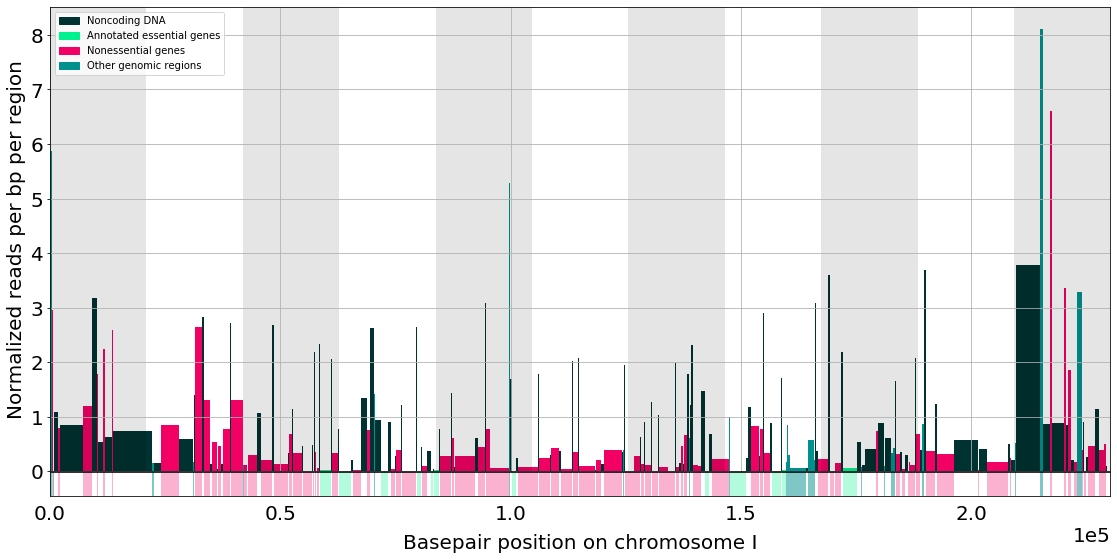

In [42]:
if plotting == True:
    noncoding_color = "#003231"
    essential_color = "#00F28E"
    nonessential_color = "#F20064"
    codingdna_color = '#00918f'
    textcolor = "#000000"
    textsize = 20


    feature_middle_pos_list = []
    sum_bp = 0
    for x in dna_df2['Nbasepairs']:
        feature_middle_pos_list.append(x/2 + sum_bp)
        sum_bp += x
    del (x, sum_bp)

    feature_width_list = list(dna_df2['Nbasepairs'])


    barcolor_list = []
    for feature in dna_df2['Feature_name']:
        if feature == 'noncoding':
            barcolor_list.append(noncoding_color)
        elif dna_df2.loc[dna_df2['Feature_name'] == feature]['Essentiality'].iloc[0] == False:
            barcolor_list.append(nonessential_color)
        elif dna_df2.loc[dna_df2['Feature_name'] == feature]['Essentiality'].iloc[0] == True:
            barcolor_list.append(essential_color)
        elif dna_df2.loc[dna_df2['Feature_name'] == feature]['Essentiality'].iloc[0] == None:
            barcolor_list.append(codingdna_color)
    del (feature)




    ###PLOTTING
    plt.figure(figsize=(19,9))
    grid = plt.GridSpec(20, 1, wspace=0.0, hspace=0.01)


    ax = plt.subplot(grid[0:19,0])
    if variable == "insertions":
        ax.bar(feature_middle_pos_list, list(dna_df2['Ninsertionsperbp']), feature_width_list, color=barcolor_list)
#        ax.set_ylim(0, max(dna_df2['Ninsertionsperbp']) + 0.1*max(dna_df2['Ninsertionsperbp']))
        ax.set_ylabel("Transposons/bp per region", fontsize=textsize, color=textcolor)
    elif variable == "reads":
        if normalize == False:
            ax.bar(feature_middle_pos_list, list(dna_df2['Nreadsperbp']), feature_width_list, color=barcolor_list)
            ax.set_ylabel("Reads/bp per region", fontsize=textsize, color=textcolor)
#                ax.set_ylim(0.0,10.0)
        elif normalize == True:
            ax.bar(feature_middle_pos_list, list(dna_df2['Nreadsperbp_normalized_byNCregions']), feature_width_list, color=barcolor_list)
#                ax.bar(feature_middle_pos_list, list(dna_df2['Nreadsperbp_normalized']), feature_width_list, color=barcolor_list)
#                ax.bar(feature_middle_pos_list, list(dna_df2['Nreadsperbp_normalized']), feature_width_list, color=barcolor_list)
            ax.set_ylabel("Normalized reads per bp per region", fontsize=textsize, color=textcolor)
#                ax.set_ylim(0.0, 150.0)

    if roi_start != None and roi_end != None and roi_start < len_chr and roi_end < len_chr:
        ax.set_xlim(roi_start, roi_end)
    else:
        ax.set_xlim(0, len_chr)

    ax.grid(linestyle='-', alpha=1.0)
    ax.tick_params(labelsize=textsize)
#    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='major', pad=30)
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax.xaxis.get_offset_text().set_fontsize(textsize)
    ax.set_xlabel("Basepair position on chromosome "+chrom, fontsize=textsize, color=textcolor, labelpad=10)
    ax.set_title(create_plottitle, fontsize=textsize, color=textcolor)
    legend_noncoding = mpatches.Patch(color=noncoding_color, label="Noncoding DNA")
    legend_essential = mpatches.Patch(color=essential_color, label="Annotated essential genes")
    legend_nonessential = mpatches.Patch(color=nonessential_color, label="Nonessential genes")
    legend_coding = mpatches.Patch(color=codingdna_color, label="Other genomic regions")
    leg = ax.legend(handles=[legend_noncoding, legend_essential, legend_nonessential, legend_coding]) #ADD
    for text in leg.get_texts():
        text.set_color(textcolor)
    del text


    count = 0
    for i in range(len(window_edge_list)-1):
        if count%2 == 0:
            ax.axvspan(window_edge_list[i], window_edge_list[i+1], facecolor=[0.0,0.0,0.0,0.1])
        else:
            ax.axvspan(window_edge_list[i], window_edge_list[i+1], facecolor=[0.0,0.0,0.0,0.0])
        count += 1


    axc = plt.subplot(grid[19,0])

    l = 0
    counter = 0
    for width in feature_width_list:
        if dna_df2.loc[counter][4] == True:
            axc.axvspan(l,l+width,facecolor=essential_color,alpha=0.3)
        elif dna_df2.loc[counter][4] == False and not dna_df2.loc[counter][0] == 'noncoding':
            axc.axvspan(l,l+width,facecolor=nonessential_color,alpha=0.3)
        elif dna_df2.loc[counter][4] == None and not dna_df2.loc[counter][0] == 'noncoding':
            axc.axvspan(l,l+width,facecolor=codingdna_color,alpha=0.5)
        l += width
        counter += 1
    if roi_start != None and roi_end != None and roi_start < len_chr and roi_end < len_chr:
        axc.set_xlim(roi_start, roi_end)
    else:
        axc.set_xlim(0, len_chr)
    axc.tick_params(labelsize=textsize)
    axc.set_yticklabels([])
    axc.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off

    axc.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,        # ticks along the bottom edge are off
        right=False,       # ticks along the top edge are off
        labelleft=False)   # labels along the bottom edge are off


    if savefigure == True:
        if normalize == True and variable == 'reads':
            saving_name = os.path.join(file_dirname,'GenomicFeaturesReads_Barplot_Chrom'+chrom+'_Normalized_with_Windowsize_'+str(normalization_window_size))
        elif normalize == False and variable == 'reads':
            saving_name = os.path.join(file_dirname,'GenomicFeaturesReads_Barplot_Chrom'+chrom+'_NonNormalized')
        else:
            saving_name = os.path.join(file_dirname,'GenomicFeaturesInsertions_Barplot_Chrom'+chrom+'_NonNormalized')
        plt.savefig(saving_name, orientation='landscape', dpi=200)
        plt.close()

    del (barcolor_list, codingdna_color, essential_color, feature_middle_pos_list, feature_width_list, noncoding_color, nonessential_color, textcolor, textsize, l, counter, width, normalization_window_size)


### Genome plots
To plot the whole genome using the dna_df2 variable, see the code [genomicfeatures_dataframe_with_normalization_genomeplot.py](https://github.com/Gregory94/LaanLab-SATAY-DataAnalysis/blob/dev_Gregory/Python_scripts/fitness_from%20SATAY_codes/genomicfeatures_dataframe_with_normalization_genomeplot.py).

I
Everything alright, just ignore me!
II
Everything alright, just ignore me!
III
Everything alright, just ignore me!
IV
Everything alright, just ignore me!
V
Everything alright, just ignore me!
VI
Everything alright, just ignore me!
VII
Everything alright, just ignore me!
VIII
Everything alright, just ignore me!
IX
Everything alright, just ignore me!
X
Everything alright, just ignore me!
XI
Everything alright, just ignore me!
XII
Everything alright, just ignore me!
XIII
Everything alright, just ignore me!
XIV
Everything alright, just ignore me!
XV
Everything alright, just ignore me!
XVI
Everything alright, just ignore me!


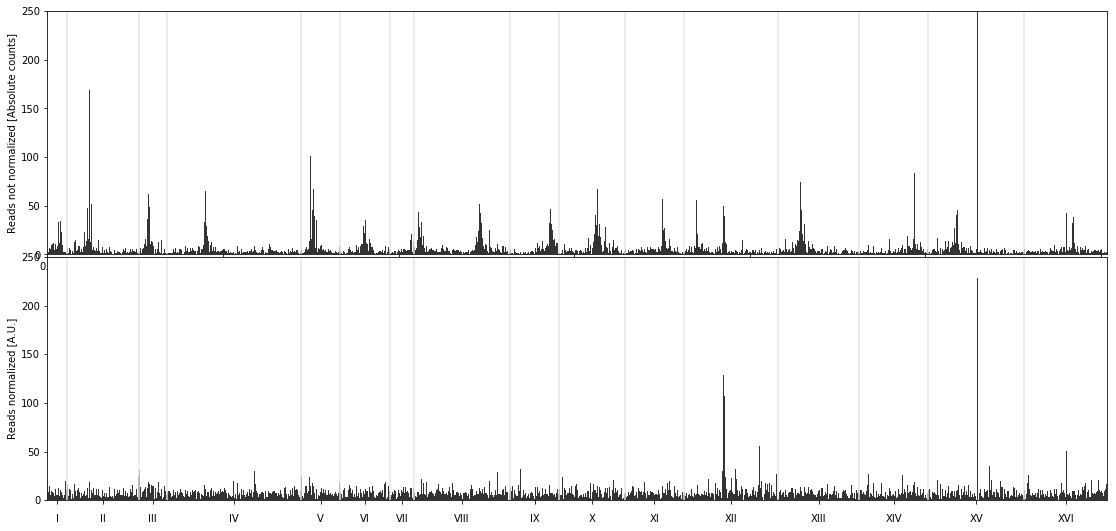

In [43]:
genome_normalization_plot()

# References

- Costanzo, M., Baryshnikova, A., VanderSluis, B., Andrews, B., Myers, C. L., & Boone, C. (2013). Genetic networks. In Handbook of Systems Biology (pp. 115-135). Elsevier Inc..
- Gallagher, L. A., Shendure, J., & Manoil, C. (2011). Genome-scale identification of resistance functions in Pseudomonas aeruginosa using Tn-seq. MBio, 2(1).
